In [42]:
import re
import itertools
from collections import Counter
import pandas as pd

import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download()
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

## Constant

In [43]:
itemID = 'asin'
userID = 'reviewerID'
rating = 'overall'
reviewText = 'reviewText'
summary = 'summary'
helpful = 'helpful'
helpful_rating = 'helpful_rating'
total_helpful = 'total_helpful'
overall = 'overall'
dataPath = 'data/ToysGames/'
dataName = 'reviews_Toys_and_Games_5.json.gz'

## Load Data

In [44]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(dataPath+dataName)[[userID, itemID, helpful, reviewText, overall, summary]]
df[reviewText] = df[reviewText].astype('str')
df[summary] = df[summary].astype('str')
df[helpful] = df[helpful].astype('str')

In [45]:
# df[["reviewerID", "asin", "helpful", "reviewText", "overall", "summary"]].to_csv("data/ToysGames/AmazonToyGamesRawData.csv", sep='\t', encoding='utf-8', index=False)

In [46]:
# df = pd.read_csv(dataPath+dataName, sep='\t', encoding='utf-8')
# df.head()

# Sort by helpfulness

In [47]:
from ast import literal_eval
df[helpful] = df[helpful].apply(lambda x: literal_eval(x))
df[helpful_rating] = df[helpful].apply(lambda x: x[0])
df[total_helpful] = df[helpful].apply(lambda x: x[1])

In [48]:
df.sort_values(by=[helpful_rating], ascending=False).head()

,reviewerID,asin,helpful,reviewText,overall,summary,helpful_rating,total_helpful
46315,A1OUQCTNVKPVR9,B0010VS078,"[1589, 1637]",I loaned my iPod to my kid and he broke it. T...,4.0,It's a great portable music solution,1589,1637
103098,A4LD7XC56J3ZV,B004Z7H07K,"[1431, 1502]",Hi! I am Erin T. and I run a website called th...,5.0,My Son Won't Put it Down,1431,1502
131030,A1SC7Z2646QCP9,B0089RPUHO,"[1413, 1449]",If you want a child-friendly tablet-style devi...,5.0,Hands down the best choice for a child-friendl...,1413,1449
80422,A3DZFEICHK5LF2,B003JQT4Y0,"[1378, 1393]","Short version:The good: The pen is amazing, a ...",3.0,Great product but a lot more parent involvement.,1378,1393
103019,A2DG63DN704LOI,B004Z7H07K,"[1291, 1359]",I really want to like the LeapPad - my kids do...,3.0,"Kids like it, but educational value is not as ...",1291,1359


In [49]:
df[df[reviewText].isnull()]

,reviewerID,asin,helpful,reviewText,overall,summary,helpful_rating,total_helpful


In [50]:
df_groupby_asin = df.groupby(itemID).agg({reviewText:','.join, summary:','.join})

In [51]:
df_groupby_asin.head()

,reviewText,summary
asin,,
0439893577,I like the item pricing. My granddaughter want...,"Magnetic board,it works pretty good for moving..."
048645195X,This is my absolute favorite design book. The ...,"Intricate,Creative, soothing and inspirational..."
0545496470,This book looks really fun and cool. Haven't o...,"Book of impossible objects,lots of stuff,Great..."
0615444172,This is a good sized book. Great quality. I b...,"good book,Two Year Old Loves This,Great sticke..."
0670010936,My son loves when we read any/all of the Llama...,"Llama Llama Cuddly!!,Love these books,Not so c..."


## Vectorize

In [52]:
tokenizer = Tokenizer()
text = df[reviewText].tolist()
tokenizer.fit_on_texts(text)

In [53]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [54]:
df_word_index.tail()

,word,index
90128,3w,90129
90129,edra,90130
90130,khz,90131
90131,newisland,90132
90132,duarable,90133


In [55]:
token_list = df[reviewText].apply(lambda x: nltk.word_tokenize(x)+[' ']).tolist()

In [56]:
token_list[0]

['I',
 'like',
 'the',
 'item',
 'pricing',
 '.',
 'My',
 'granddaughter',
 'wanted',
 'to',
 'mark',
 'on',
 'it',
 'but',
 'I',
 'wanted',
 'it',
 'just',
 'for',
 'the',
 'letters',
 '.',
 ' ']

# Remove Stop Words

In [57]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))

#filter out stopwords
for i in range(len(token_list)):
    token_list[i] = [w for w in token_list[i] if not w in en_stopwords]

In [58]:
token_list[0]

['I',
 'like',
 'item',
 'pricing',
 '.',
 'My',
 'granddaughter',
 'wanted',
 'mark',
 'I',
 'wanted',
 'letters',
 '.',
 ' ']

# Remove Punctuation

In [59]:
import string
table = str.maketrans('', '', string.punctuation)
for i in range(len(token_list)):
    token_list[i] = [w.translate(table) for w in token_list[i]]

In [60]:
token_list[0]

['I',
 'like',
 'item',
 'pricing',
 '',
 'My',
 'granddaughter',
 'wanted',
 'mark',
 'I',
 'wanted',
 'letters',
 '',
 ' ']

# Remove tokens that are not alphabetic

In [61]:
for i in range(len(token_list)):
    token_list[i] = [word for word in token_list[i] if word.isalpha()]

In [62]:
token_list[0]

['I',
 'like',
 'item',
 'pricing',
 'My',
 'granddaughter',
 'wanted',
 'mark',
 'I',
 'wanted',
 'letters']

# Lowercase

In [63]:
for i in range(len(token_list)):
    token_list[i] = [w.lower() for w in token_list[i]]

In [64]:
token_list[0]

['i',
 'like',
 'item',
 'pricing',
 'my',
 'granddaughter',
 'wanted',
 'mark',
 'i',
 'wanted',
 'letters']

# Stemming

In [65]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
for i in range(len(token_list)):
    token_list[i] = [porter.stem(word) for word in token_list[i]]

In [66]:
token_list[0]

['i',
 'like',
 'item',
 'price',
 'my',
 'granddaught',
 'want',
 'mark',
 'i',
 'want',
 'letter']

# Filter ADJ/NN

In [67]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    elif len(tags) == 3:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in acceptable_types and tags[3][1] in second_type:
            return True
        else:
            return False  

# Bigram

In [68]:
bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# bigramFreqTable = bigramFreqTable[bigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [69]:
bigramFreqTable.head(50)

,ngram,freq
445,"(year, old)",40045
125,"(it, s)",22024
1063,"(i, would)",16854
774,"(i, think)",14942
130,"(i, m)",14458
803,"(i, nt)",14020
46,"(i, bought)",13629
1056,"(my, son)",11165
1836,"(ca, nt)",11114
1099,"(my, daughter)",10714


In [70]:
# trigrams = nltk.collocations.TrigramAssocMeasures()
# tokens = itertools.chain.from_iterable(token_list)
# trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
# trigram_freq = trigramFinder.ngram_fd.items()

# trigramFreqTable = pd.DataFrame(list(trigram_freq), 
#                                 columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# trigramFreqTable = trigramFreqTable[trigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [71]:
# trigramFreqTable.head(50)

In [72]:
finder = nltk.collocations.TrigramCollocationFinder.from_words(["what","the","hell"])
finder.ngram_fd.items()

dict_items([(('what', 'the', 'hell'), 1)])

In [82]:
bigramFinder.apply_freq_filter(100)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: rightTypes(x))]
bigramPMITable

,bigram,PMI
19,"(mega, blok)",13.467095
22,"(sesam, street)",13.401035
26,"(forbidden, island)",13.041729
35,"(usb, cabl)",12.609000
40,"(english, spanish)",12.409001
60,"(angri, bird)",11.622920
73,"(littlest, pet)",11.035892
86,"(rapid, fire)",10.776710
90,"(wooden, railway)",10.645347
94,"(elementari, school)",10.453375


In [83]:
# bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: rightTypes(x))]
# bigramPMITable

In [84]:
bigram_freq_pmi = pd.merge(bigramFreqTable, bigramPMITable, how='right', left_on='ngram', right_on='bigram').sort_values("PMI", ascending=False)
bigram_freq_pmi.head(50)

,ngram,freq,bigram,PMI
356,"(mega, blok)",200,"(mega, blok)",13.467095
134,"(sesam, street)",454,"(sesam, street)",13.401035
538,"(forbidden, island)",144,"(forbidden, island)",13.041729
573,"(usb, cabl)",137,"(usb, cabl)",12.609000
760,"(english, spanish)",106,"(english, spanish)",12.409001
40,"(angri, bird)",1074,"(angri, bird)",11.622920
283,"(littlest, pet)",246,"(littlest, pet)",11.035892
796,"(rapid, fire)",102,"(rapid, fire)",10.776710
245,"(wooden, railway)",284,"(wooden, railway)",10.645347
747,"(elementari, school)",108,"(elementari, school)",10.453375


In [85]:
bigram_freq_pmi.head(50)['freq'].sum()

13804

In [86]:
bigram_freq_pmi.head(50)['PMI'].sum()

468.1428837557626

In [87]:
#df_keyphrases = pd.concat([bigramFreqTable[['bigram']].head(50), bigramPMITable[['bigram']].head(50)])
df_keyphrases = bigram_freq_pmi[['bigram']].head(50)
df_keyphrases['Phrases'] = df_keyphrases['bigram'].apply(lambda x: ' '.join(x))
df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
keyphrases = df_keyphrases['Phrases'].tolist()

In [88]:
df["keyphrases_indices"] = df[reviewText].apply(lambda x: [keyphrases.index(key) for key in keyphrases if key in x])
df['keyphrases_indices_length'] = df['keyphrases_indices'].str.len()
df

,reviewerID,asin,helpful,reviewText,overall,summary,helpful_rating,total_helpful,keyphrases_indices,keyphrases_indices_length
0,A1VXOAVRGKGEAK,0439893577,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,0,0,[],0
1,A8R62G708TSCM,0439893577,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,1,1,[],0
2,A21KH420DK0ICA,0439893577,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,1,1,[],0
3,AR29QK6HPFYZ4,0439893577,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,0,0,[],0
4,ACCH8EOML6FN5,0439893577,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,1,1,[],0
5,A1EDPGHC9EYBUN,0439893577,"[0, 0]",this is a nice magnetic board for the kids to ...,3.0,grandma,0,0,[],0
6,A181ZNB42LISRZ,0439893577,"[0, 0]",This is just as I expected. It's not too sturd...,3.0,Serves the purpose,0,0,[],0
7,A1RBEJ5UQ1RWAW,0439893577,"[1, 1]",My granddaughter really really likes this. I l...,5.0,Great,1,1,[],0
8,AFGGC7SIV964O,0439893577,"[0, 0]",This is good product to have with unlimited po...,4.0,A must have for any homeschooling classroom !,0,0,[],0
9,A2XU46XXNV19C8,0439893577,"[59, 59]",I keep this board on top of the hallway table ...,3.0,Nifty little thing,59,59,[],0


In [89]:
print(df['keyphrases_indices_length'].sum())
print(df['keyphrases_indices_length'].sum() / len(df))

5459
0.032572182079631494


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b19cb2cc0>]],
      dtype=object)

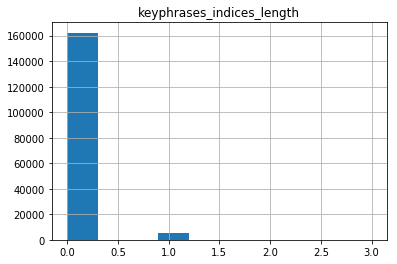

In [90]:
df.hist(column='keyphrases_indices_length')

In [42]:
df[reviewText].apply(lambda x: [keyphrases.index(key) for key in keyphrases if key in x]).str.len().sum()

1329

In [52]:
df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
11        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
12        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [99]:
df['keyVector'] = df[reviewText].apply(lambda x: [1. if key in x else 0 for key in keyphrases])

In [100]:
df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
df['Binary'] = (df[rating] > 3)*1

In [101]:
df_user_name = df[['UserIndex',userID]]
df_item_name = df[['ItemIndex',itemID]]

In [53]:
# df = df.drop([itemID, userID, reviewText], axis=1)

## DataFrames

In [102]:
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,helpful_rating,total_helpful,keyVector,UserIndex,ItemIndex,Binary
0,A1VXOAVRGKGEAK,0439893577,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4516,0,1
1,A8R62G708TSCM,0439893577,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15552,0,1
2,A21KH420DK0ICA,0439893577,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5307,0,1
3,AR29QK6HPFYZ4,0439893577,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18104,0,1
4,ACCH8EOML6FN5,0439893577,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16040,0,1


In [103]:
df_word_index.head()

,word,index
0,the,1
1,and,2
2,a,3
3,to,4
4,it,5


In [104]:
df_keyphrases.head()

,Phrases
0,Puerto Rico
1,Against Humanity
2,Strawberry Shortcake
3,Lincoln Logs
4,Harry Potter


In [105]:
df_user_name.head()

,UserIndex,reviewerID
0,4516,A1VXOAVRGKGEAK
1,15552,A8R62G708TSCM
2,5307,A21KH420DK0ICA
3,18104,AR29QK6HPFYZ4
4,16040,ACCH8EOML6FN5


In [106]:
df_item_name.head()

,ItemIndex,asin
0,0,0439893577
1,0,0439893577
2,0,0439893577
3,0,0439893577
4,0,0439893577


## Statistic

In [107]:
print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))

Number of User: 19412
Number of Item: 11924
Number of Positive Review: 140235


In [111]:
df['vector'] = tokenizer.texts_to_sequences(text)

In [112]:
review_lengths = df.vector.apply(lambda x: len(x)).tolist()

/home/kai/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


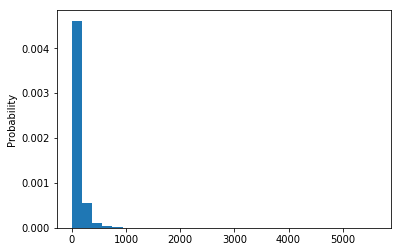

In [113]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(review_lengths, normed=True, bins=30)
plt.ylabel('Probability');

## Save

In [116]:
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')